In [4]:
import pandas as pd
import math
from collections import Counter
# import time as t
from tqdm import tqdm 
import random

In [8]:
data = pd.read_csv('Breast_Cancer.csv')

In [9]:
def compute_distances(point1, point2):
    """
        Age, survival months, regional node positive, regional node examined and Tumor size
        are the continuous variables. Euclidean distance is used for measuring similarity 
        between these variables.

        Race, Marital Status, T Stage, N Stage, 6th Stage, Defferentiated, Grade, A Stage, 
        Estrogen Status, Progesterone Status are the categorical values. Hamming distance 
        is used for measuring the similarity across these variables.
    """
    euclidean_distance = math.sqrt(
        (point1['Age'] - point2['Age'] ) **2+
        (point1['Tumor Size'] - point2['Tumor Size'] ) **2+
        (point1['Regional Node Examined'] - point2['Regional Node Examined']) **2+
        (point1['Regional Node Positive'] - point2['Regional Node Positive'] ) **2+
        (point1['Survival Months'] - point2['Survival Months'])**2
    )

    # print("ed: ", euclidean_distance)

    

    hamming_distance = (
        (0 if point1['Race']==point2['Race'] else 1) + 
        (0 if point1['Marital Status']==point2['Marital Status'] else 1) +
        (0 if point1['T Stage']==point2['T Stage'] else 1) +
        (0 if point1['N Stage']==point2['N Stage'] else 1) +
        (0 if point1['6th Stage']==point2['6th Stage'] else 1) +
        (0 if point1['differentiate']==point2['differentiate'] else 1) +
        (0 if point1['Grade']==point2['Grade'] else 1) +
        (0 if point1['A Stage']==point2['A Stage'] else 1) +
        (0 if point1['Estrogen Status']==point2['Estrogen Status'] else 1) +
        (0 if point1['Progesterone Status']==point2['Progesterone Status'] else 1) 
    )
    
    
    # print("hd: ", hamming_distance)
    return euclidean_distance + hamming_distance

In [18]:
def split_dataset(data):
    totalRows = data.shape[0] - 1

    """
        split data into train, validation and testing sets : 75-15-15% each
        find the total size of the dataset and *0.75, .15, .15
    """    
    train_boundary = math.floor(0.70*totalRows)
    val_boundary = train_boundary + math.ceil(0.15*totalRows)
    test_boundary = val_boundary + math.ceil(0.15*totalRows)

    train_data = data.iloc[:train_boundary]
    val_data = data.iloc[train_boundary:val_boundary]
    test_data = data.iloc[val_boundary:test_boundary]

    train_Y = train_data['Status']
    train_X = train_data.drop(['Status'], axis=1)

    val_Y = val_data['Status']
    val_X = val_data.drop(['Status'], axis=1)


    test_Y = test_data['Status']
    test_X = test_data.drop(['Status'], axis=1)

    # print(train_X.shape[0])
    # print(val_X.shape[0])

    return train_X, train_Y, val_X, val_Y, test_X, test_Y

In [28]:
data['ID'] = data.index
train_X, train_Y, val_X, val_Y, test_X, test_Y = split_dataset(data.sample(frac=1))

In [40]:
point_distance_map = {}
val_point_to_sorted_distances = {}

In [ ]:
for val_index in tqdm(range(val_X.shape[0])):
    for train_index in range(train_X.shape[0]):
        distance = compute_distances(val_X.iloc[val_index], train_X.iloc[train_index])
        point_distance_map[train_index] = distance
    sorted_distances = dict(sorted(point_distance_map.items(), key=lambda item: item[1]))
    val_point_to_sorted_distances[val_index] = sorted_distances

In [149]:
def get_k_neighbours(k):
    kNeighbours = {}
    for val_point in val_point_to_sorted_distances:
        neighbours = val_point_to_sorted_distances[val_point]
        kNeighbours[val_point] = list(neighbours.keys())[:k]
    return kNeighbours
    

def predict_for_val(kNeighbours):
    validation_predictions = {}
    for val_point in kNeighbours.keys():
        output = []
        for neigh in kNeighbours[val_point]:
            # print(train_X.loc[train_X['ID'] == neigh])
            output.append(train_Y.iloc[neigh])
            pred_status, trash = Counter(output).most_common()[0]
            validation_predictions[val_point] = pred_status
    return validation_predictions


tp = {}
fp = {}
tn = {}
fn = {}

def confusion_matrix(predictions, k, actual_Y):
    global tp
    global tn
    global fn
    global fp
    tp.setdefault(k,0)
    tn.setdefault(k,0)
    fn.setdefault(k,0)
    fp.setdefault(k,0)
    for point in predictions:    
        if predictions[point] == actual_Y.iloc[point]:
            if actual_Y.iloc[point] == 'Alive': 
                
                tp[k]+=1
            else:
                tn[k]+=1
        else:
            if actual_Y.iloc[point] == 'Alive':
                fn[k]+=1
            else:
                fp[k]+=1


def compute_accuracies(tp, fp, tn, fn, k):
    recall_1 = tp[k]/(tp[k]+fn[k])
    recall_2 = tn[k]/(tn[k]+fp[k])
    return ((tp[k]+tn[k])/(tp[k]+tn[k]+fp[k]+tn[k])) , (0.5*(recall_1 + recall_2)) , (2*tp[k] / (2*tp[k] + fp[k] + fn[k]))



In [162]:
accuracies = []
bAccuracies = []
f1_scores = []

In [163]:
for k in [1,3,5,7,9,11]:
    kNeighbours = get_k_neighbours(k)
    validation_predictions = predict_for_val(kNeighbours=kNeighbours)
    confusion_matrix(validation_predictions, k, val_Y)
    acc , bAcc , f1 = compute_accuracies(tp, fp, tn, fn, k)
    accuracies.append(acc)
    bAccuracies.append(bAcc)
    f1_scores.append(f1)
    print(f"For k = {k} :  Accuracy = {acc}------Balanced Accuracy = {bAcc}------F1 score = {f1}")
    print("==================================================================================================================")

For k = 1 :  Accuracy = 0.8407960199004975------Balanced Accuracy = 0.6553067585301837------F1 score = 0.9064609450337512
For k = 3 :  Accuracy = 0.8433931484502447------Balanced Accuracy = 0.6567011154855643------F1 score = 0.917221693625119
For k = 5 :  Accuracy = 0.8456591639871383------Balanced Accuracy = 0.6655593832020997------F1 score = 0.9264150943396227
For k = 7 :  Accuracy = 0.8459069020866774------Balanced Accuracy = 0.6623195538057743------F1 score = 0.9275634995296331
For k = 9 :  Accuracy = 0.8426892950391645------Balanced Accuracy = 0.6279963639811791------F1 score = 0.9176382098533283
For k = 11 :  Accuracy = 0.8427919112850619------Balanced Accuracy = 0.6250290194847448------F1 score = 0.9181681681681682


Best value for K based on :
    1. Accuracy : K*=9
    2. Balanced accuracy : K**=9
    3. F1 score : K+=11

In [164]:
accuracies

[0.8407960199004975,
 0.8433931484502447,
 0.8456591639871383,
 0.8459069020866774,
 0.8426892950391645,
 0.8427919112850619]

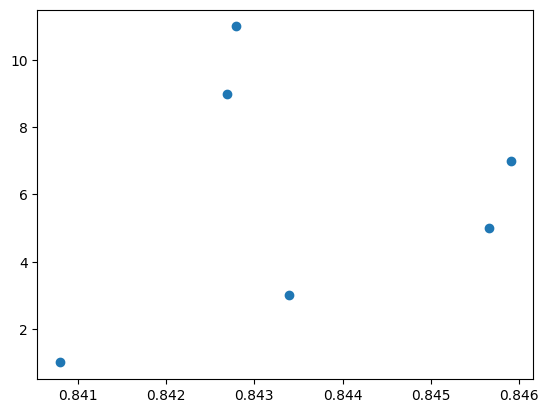

In [165]:
import matplotlib.pyplot as plt
plt.scatter(accuracies, [1,3,5,7,9,11])

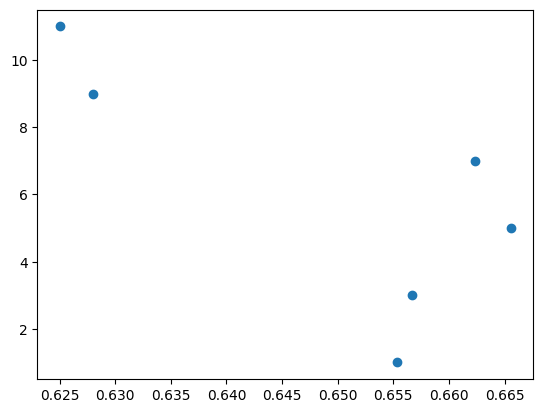

In [166]:
plt.scatter(bAccuracies, [1,3,5,7,9,11])

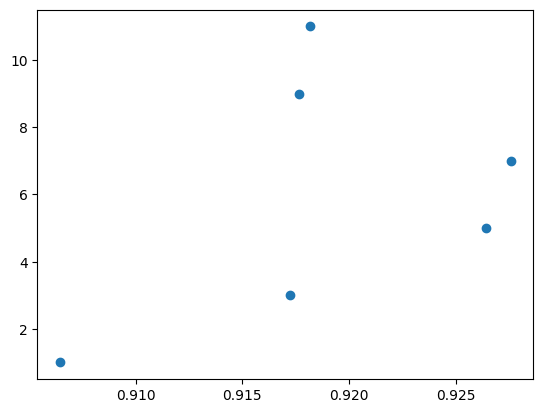

In [169]:
plt.scatter(f1_scores, [1,3,5,7,9,11])

In [144]:
point_distance_map = {}
test_point_to_sorted_distances = {}

In [145]:
for test_index in tqdm(range(test_X.shape[0])):
    for train_index in range(train_X.shape[0]):
        distance = compute_distances(test_X.iloc[test_index], train_X.iloc[train_index])
        point_distance_map[train_index] = distance
    sorted_distances = dict(sorted(point_distance_map.items(), key=lambda item: item[1]))
    test_point_to_sorted_distances[test_index] = sorted_distances

100%|██████████| 604/604 [02:01<00:00,  4.99it/s]


In [146]:
def get_k_neighbours(k):
    kNeighbours = {}
    for test_point in test_point_to_sorted_distances:
        neighbours = test_point_to_sorted_distances[test_point]
        kNeighbours[test_point] = list(neighbours.keys())[:k]
    return kNeighbours

In [147]:
def predict_for_test(kNeighbours):
    test_predictions = {}
    for test_point in kNeighbours.keys():
        output = []
        for neigh in kNeighbours[test_point]:
            # print(train_X.loc[train_X['ID'] == neigh])
            output.append(train_Y.iloc[neigh])
            pred_status, trash = Counter(output).most_common()[0]
            test_predictions[test_point] = pred_status
    return test_predictions

In [150]:
for k in [9,11]:
    kNeighbours = get_k_neighbours(k)
    test_predictions = predict_for_test(kNeighbours=kNeighbours)
    confusion_matrix(test_predictions, k, test_Y)
    acc , bAcc , f1 = compute_accuracies(tp, fp, tn, fn, k)
    print(f"For k = {k} :  Accuracy = {acc}------Balanced Accuracy = {bAcc}------F1 score = {f1}")
    print("==================================================================================================================")

For k = 9 :  Accuracy = 0.825------Balanced Accuracy = 0.4647495361781076------F1 score = 0.8662900188323918
For k = 11 :  Accuracy = 0.8256227758007118------Balanced Accuracy = 0.46672582076308783------F1 score = 0.868421052631579


In [172]:
tp_W = 0
tn_W = 0
fn_W = 0
fp_W = 0

tp_B = 0
tn_B = 0
fn_B = 0
fp_B = 0

tp_O = 0
tn_O = 0
fn_O = 0
fp_O = 0

In [184]:
def confusion_matrix_optimal(predictions, k, actual_Y):
    for point in predictions:  
        if test_X.iloc[point]['Race'] == "White" :  
            if predictions[point] == actual_Y.iloc[point]:
                if actual_Y.iloc[point] == 'Alive': 
                    global tp_W
                    tp_W+=1
                else:
                    global tn_W
                    tn_W+=1
            else:
                if actual_Y.iloc[point] == 'Alive':
                    global fn_W
                    fn_W+=1
                else:
                    global fp_W
                    fp_W+=1
        elif test_X.iloc[point]['Race'] == "Black":
            if predictions[point] == actual_Y.iloc[point]:
                if actual_Y.iloc[point] == 'Alive': 
                    global tp_B
                    tp_B+=1
                else:
                    global tn_B
                    tn_B+=1
            else:
                if actual_Y.iloc[point] == 'Alive':
                    global fn_B
                    fn_B+=1
                else:
                    global fp_B
                    fp_B+=1
        elif test_X.iloc[point]['Race'] == "Other":
            if predictions[point] == actual_Y.iloc[point]:
                if actual_Y.iloc[point] == 'Alive': 
                    global tp_O
                    tp_O+=1
                else:
                    global tn_O
                    tn_O+=1
            else:
                if actual_Y.iloc[point] == 'Alive':
                    global fn_O
                    fn_O+=1 
                else:
                    global fp_O
                    fp_O+=1


In [188]:
kNeighbours = get_k_neighbours(11)
test_predictions = predict_for_test(kNeighbours)
confusion_matrix_optimal(test_predictions, 11, test_Y)

In [189]:
def compute_accuracies_optimal(tp, fp, tn, fn, k):
    recall_1 = tp/(tp+fn)
    recall_2 = tn/(tn+fp)
    return ((tp+tn)/(tp+tn+fp+tn)) , (0.5*(recall_1 + recall_2)) , (2*tp / (2*tp + fp + fn))


In [190]:
f1_W = compute_accuracies_optimal(tp=tp_W, tn=tn_W, fp=fp_W, fn=fn_W, k=11)
f1_B = compute_accuracies_optimal(tp=tp_B, tn=tn_B, fp=fp_B, fn=fn_B, k=11)
f1_O = compute_accuracies_optimal(tp=tp_O, tn=tn_O, fp=fp_O, fn=fn_O, k=11)

In [192]:
f1_W[2], f1_B[2], f1_O[2]

(0.8706009745533297, 0.8387096774193549, 0.8641975308641975)